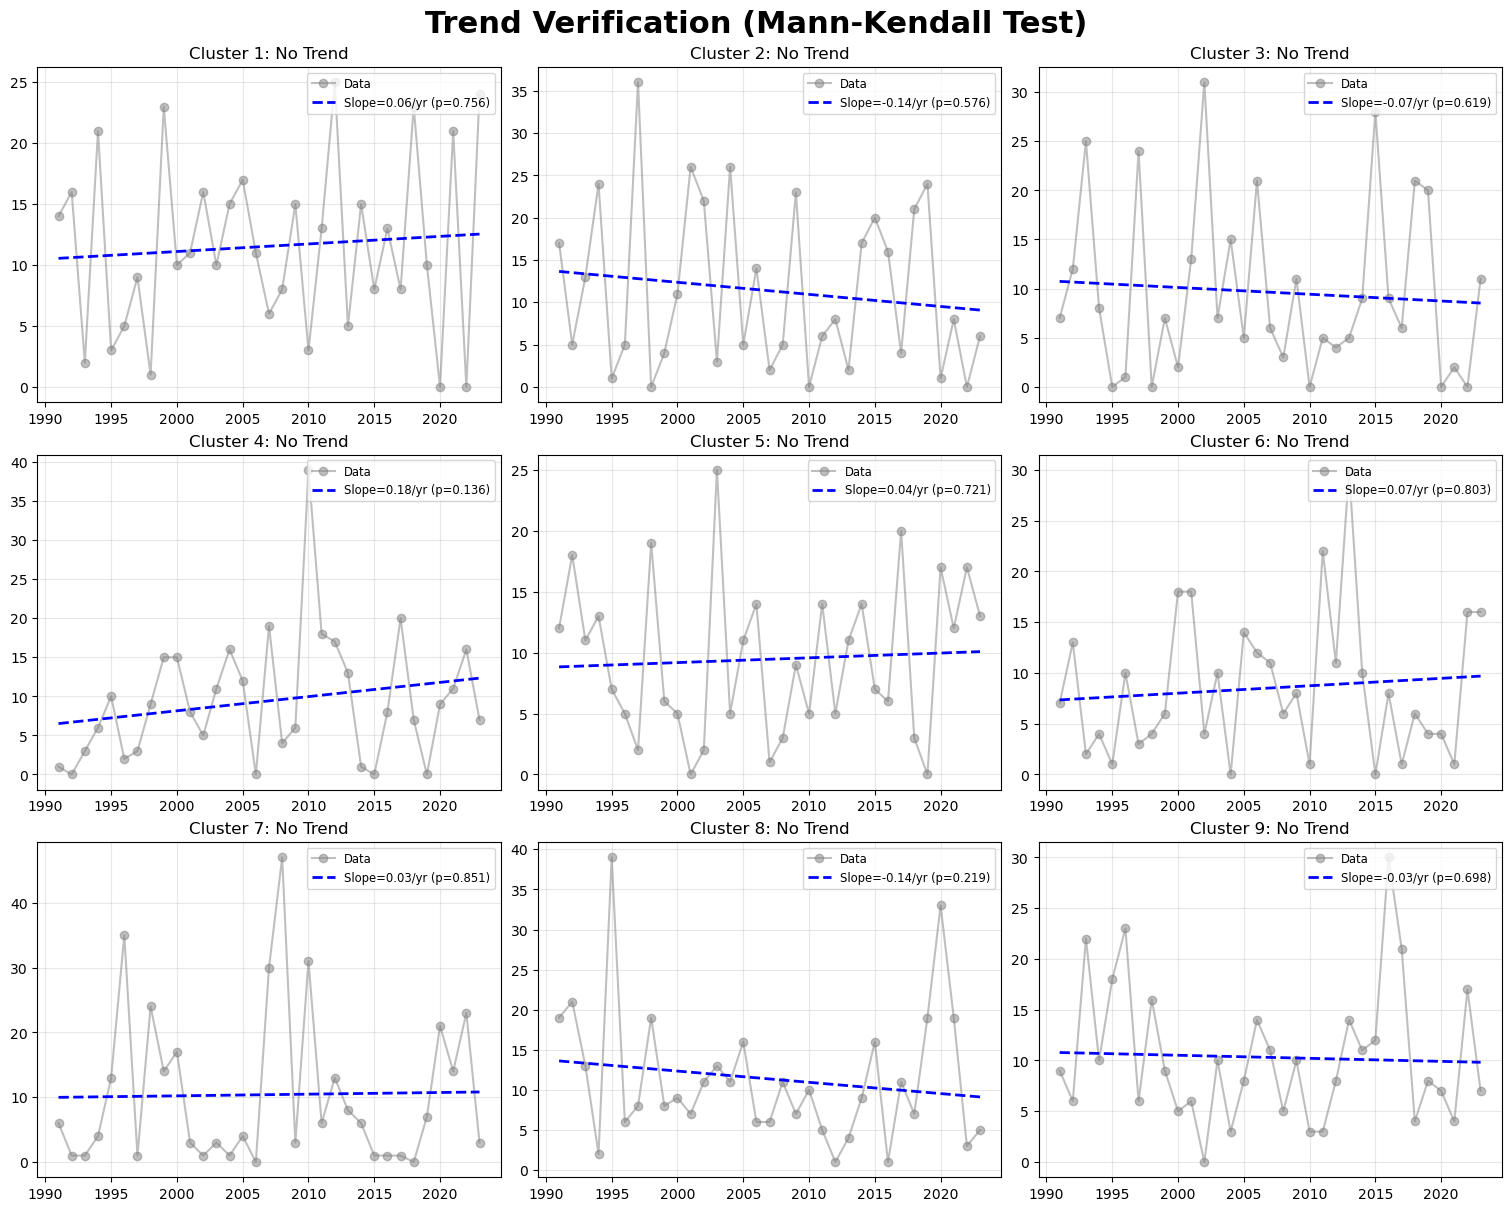

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. Load Data
counts = pd.read_csv("../Data/u850_cluster_counts.csv")
years = counts["year"].values


# 2. Mann-Kendall Test Function (Non-parametric)
def mann_kendall_test(y):
    n = len(y)
    s = 0
    # Calculate S statistic
    for k in range(n - 1):
        for j in range(k + 1, n):
            s += np.sign(y[j] - y[k])

    # Calculate Variance with tie correction
    unique_vals, tp = np.unique(y, return_counts=True)
    var_s = (n * (n - 1) * (2 * n + 5) - np.sum(tp * (tp - 1) * (2 * tp + 5))) / 18

    # Calculate Z statistic
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0

    # Two-tailed P-value
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p


# 3. Analyze & Plot
fig, axs = plt.subplots(3, 3, figsize=(15, 12), constrained_layout=True)

for i, ax in enumerate(axs.flatten()):
    y = counts.iloc[:, i + 1].values
    cluster_name = counts.columns[i + 1]

    # Linear Regression (for slope magnitude)
    slope, intercept, _, p_lin, _ = stats.linregress(years, y)
    trend_line = slope * years + intercept

    # Mann-Kendall Test (for statistical significance)
    z_mk, p_mk = mann_kendall_test(y)

    # Determine Status
    is_sig = p_mk < 0.05
    status = "Trend" if is_sig else "No Trend"
    color = "red" if is_sig else "blue"
    style = "-" if is_sig else "--"

    # Plotting
    ax.plot(years, y, "o-", color="gray", alpha=0.5, label="Data")
    ax.plot(
        years,
        trend_line,
        color=color,
        linestyle=style,
        linewidth=2,
        label=f"Slope={slope:.2f}/yr (p={p_mk:.3f})",
    )

    ax.set_title(f"Cluster {i + 1}: {status}")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize="small", loc="upper right")

fig.suptitle("Trend Verification (Mann-Kendall Test)", fontsize=22, fontweight="bold")
plt.savefig("../Results/u850a_cluster_ts_trends.png", dpi=144)

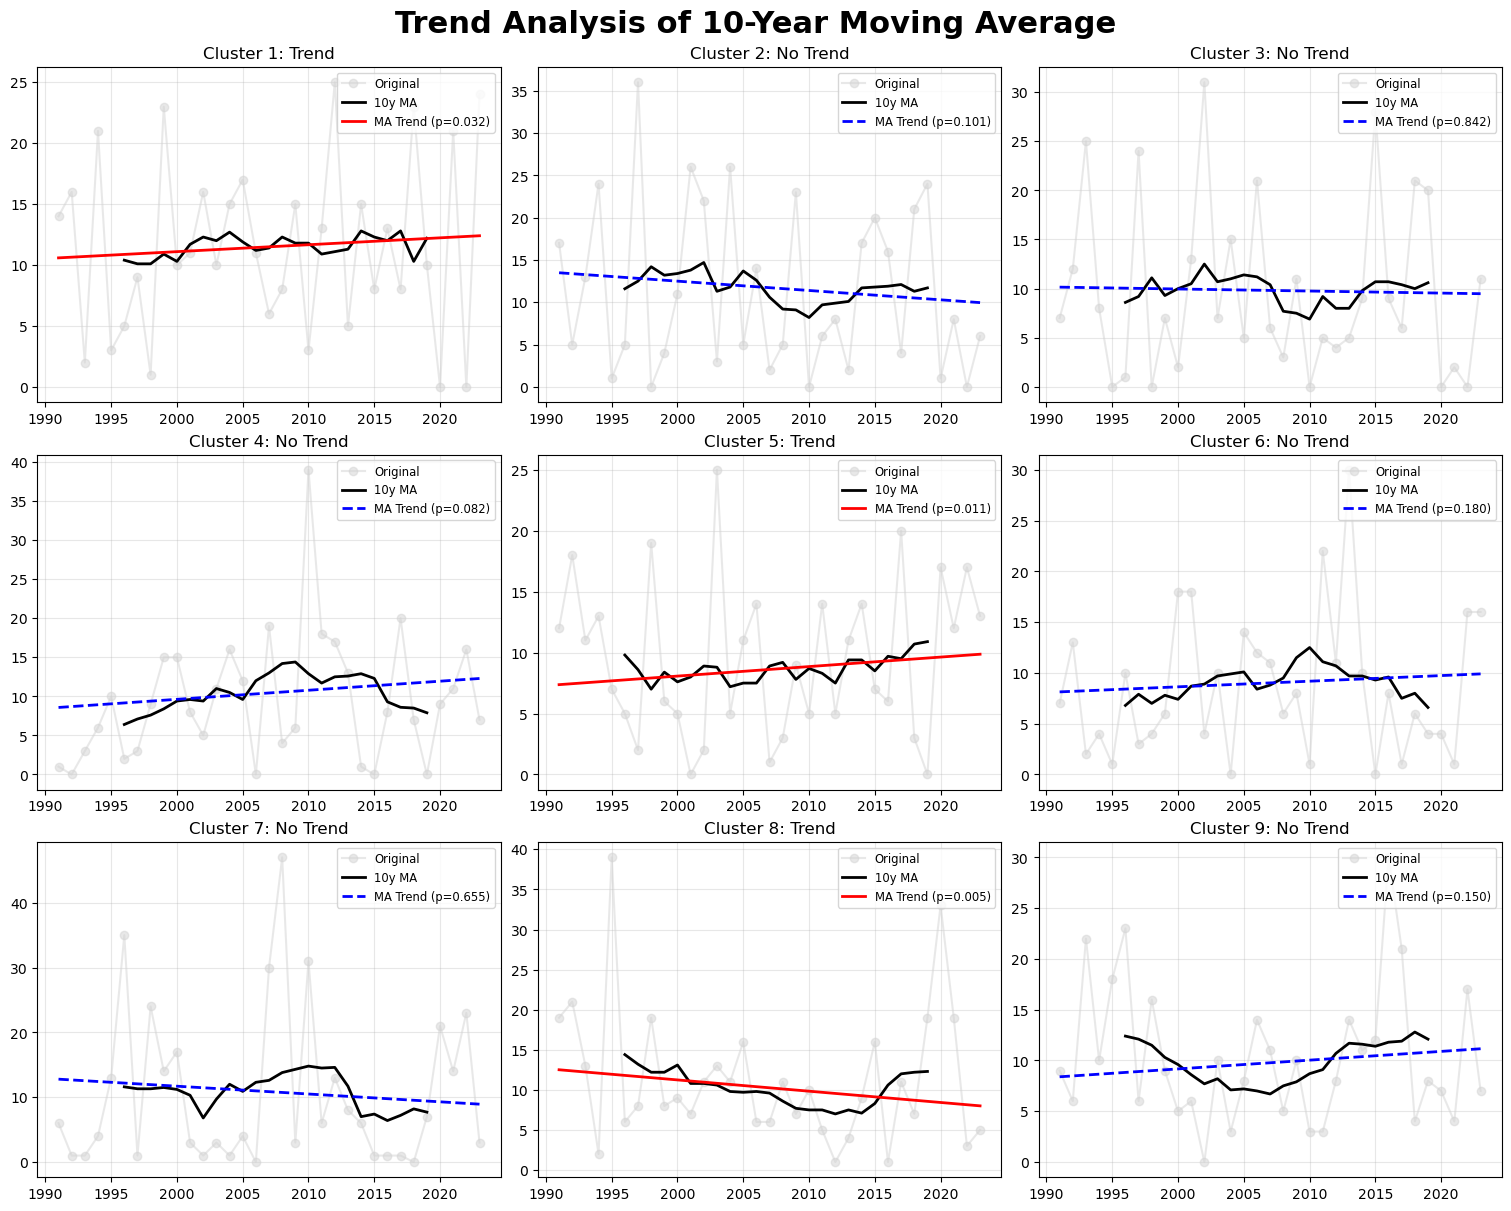

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. Load Data
counts = pd.read_csv("../Data/u850_cluster_counts.csv")
years = counts["year"].values


# 2. Mann-Kendall Test Function (Non-parametric)
def mann_kendall_test(y):
    n = len(y)
    s = 0
    # Calculate S statistic
    for k in range(n - 1):
        for j in range(k + 1, n):
            s += np.sign(y[j] - y[k])

    # Calculate Variance with tie correction
    unique_vals, tp = np.unique(y, return_counts=True)
    var_s = (n * (n - 1) * (2 * n + 5) - np.sum(tp * (tp - 1) * (2 * tp + 5))) / 18

    # Calculate Z statistic
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0

    # Two-tailed P-value
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p


# 3. Analyze & Plot
fig, axs = plt.subplots(3, 3, figsize=(15, 12), constrained_layout=True)

for i, ax in enumerate(axs.flatten()):
    y = counts.iloc[:, i + 1].values
    cluster_name = counts.columns[i + 1]

    # --- [수정] 10년 이동평균 계산 (중앙 정렬) ---
    y_series = pd.Series(y)
    y_ma = y_series.rolling(window=10, center=True).mean()

    # 통계 검정을 위해 NaN 값 제거 (양 끝단)
    valid_mask = ~y_ma.isna()
    y_ma_valid = y_ma[valid_mask].values
    years_valid = years[valid_mask]

    # 데이터 포인트가 충분한지 확인
    if len(y_ma_valid) > 3:
        # 1. 선형 회귀 (기울기 계산)
        slope, intercept, _, p_lin, _ = stats.linregress(years_valid, y_ma_valid)
        trend_line = slope * years + intercept

        # 2. Mann-Kendall 검정 (유의성 확인)
        z_mk, p_mk = mann_kendall_test(y_ma_valid)
        is_sig = p_mk < 0.05
    else:
        slope, p_mk, is_sig = 0, 1.0, False
        trend_line = np.zeros_like(years)

    # 시각화 설정
    status = "Trend" if is_sig else "No Trend"
    color = "red" if is_sig else "blue"
    style = "-" if is_sig else "--"

    # Plotting
    ax.plot(years, y, "o-", color="lightgray", alpha=0.5, label="Original")
    ax.plot(years, y_ma, "-", color="black", linewidth=2, label="10y MA")
    ax.plot(
        years,
        trend_line,
        color=color,
        linestyle=style,
        linewidth=2,
        label=f"MA Trend (p={p_mk:.3f})",
    )

    ax.set_title(f"Cluster {i + 1}: {status}")
    ax.grid(True, alpha=0.3)

    ax.legend(fontsize="small", loc="upper right")

fig.suptitle("Trend Analysis of 10-Year Moving Average", fontsize=22, fontweight="bold")
plt.savefig("../Results/ma_10y_trend_analysis.png", dpi=144)
plt.show()